# Exploration and Comparison of Transformers for Image Classification

## Linear Probing using Data-efficient image Transformer (DeiT)

Linear Probing is an experiment that involes training a linear classifier on top of pre-trained frozen features of the model.

In this experiment, the whole training set is used.

### Data-efficient image Transformer (DeiT)

Distilled data-efficient Image Transformer (DeiT) model pre-trained and fine-tuned on ImageNet-1k (1 million images, 1,000 classes) at resolution 224x224. It was first introduced in the paper *Training data-efficient image transformers & distillation through attention by Touvron et al.*

https://arxiv.org/abs/2012.12877

### Prerequisites

Load necessary packages.

In [1]:
import os
os.chdir('../../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [2]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [3]:
id = 10
torch.manual_seed(10)

Load DeiT image processor used for image pre-processing.

In [4]:
processor = get_backbone_processor(model_names['DeiT'])

Print the pre-processing operations done by the processor.

In [5]:
processor

DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [7]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [9]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [11]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [13]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [15]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

#### DTD

In [17]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for experiments and print its settings.

In [18]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=1e-4,
    optimizer=AdamW,
    weight_decay=0
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 0.0001,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0}

Create empty array to store dataset accuracies for each experiment.

In [19]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Linear Probing


Train a new linear classifier on top of pre-trained model base.

Teacher model (RegNet) is trained using the same configuration.

#### RESISC45

In [20]:
teacher_resisc45 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
get_model_params(teacher_resisc45)

Parameters: 80.70M


In [22]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 2363/2363 [01:50<00:00, 21.41it/s]


Epochs: 1/10 | train_loss: 2.3601 | train_acc: 0.4894


100%|██████████| 2363/2363 [01:49<00:00, 21.53it/s]


Epochs: 2/10 | train_loss: 1.4339 | train_acc: 0.6632


100%|██████████| 2363/2363 [01:48<00:00, 21.70it/s]


Epochs: 3/10 | train_loss: 1.1741 | train_acc: 0.7050


100%|██████████| 2363/2363 [01:51<00:00, 21.27it/s]


Epochs: 4/10 | train_loss: 1.0226 | train_acc: 0.7346


100%|██████████| 2363/2363 [01:48<00:00, 21.77it/s]


Epochs: 5/10 | train_loss: 0.9427 | train_acc: 0.7462


100%|██████████| 2363/2363 [01:48<00:00, 21.70it/s]


Epochs: 6/10 | train_loss: 0.8697 | train_acc: 0.7643


100%|██████████| 2363/2363 [01:48<00:00, 21.71it/s]


Epochs: 7/10 | train_loss: 0.8270 | train_acc: 0.7772


100%|██████████| 2363/2363 [01:48<00:00, 21.78it/s]


Epochs: 8/10 | train_loss: 0.7865 | train_acc: 0.7820


100%|██████████| 2363/2363 [01:48<00:00, 21.80it/s]


Epochs: 9/10 | train_loss: 0.7494 | train_acc: 0.7928


100%|██████████| 2363/2363 [01:51<00:00, 21.14it/s]

Epochs: 10/10 | train_loss: 0.7199 | train_acc: 0.7983


In [23]:
deit_resisc45 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
get_model_params(deit_resisc45)

Parameters: 85.87M


In [25]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_resisc45,
)

100%|██████████| 2363/2363 [04:31<00:00,  8.71it/s]


Epochs: 1/10 | train_loss: 2.0375 | train_acc: 0.6231


100%|██████████| 2363/2363 [04:32<00:00,  8.67it/s]


Epochs: 2/10 | train_loss: 0.9374 | train_acc: 0.8212


100%|██████████| 2363/2363 [04:32<00:00,  8.67it/s]


Epochs: 3/10 | train_loss: 0.7187 | train_acc: 0.8490


100%|██████████| 2363/2363 [04:31<00:00,  8.70it/s]


Epochs: 4/10 | train_loss: 0.6247 | train_acc: 0.8694


100%|██████████| 2363/2363 [04:32<00:00,  8.68it/s]


Epochs: 5/10 | train_loss: 0.5697 | train_acc: 0.8811


100%|██████████| 2363/2363 [04:32<00:00,  8.66it/s]


Epochs: 6/10 | train_loss: 0.5335 | train_acc: 0.8904


100%|██████████| 2363/2363 [04:31<00:00,  8.72it/s]


Epochs: 7/10 | train_loss: 0.5068 | train_acc: 0.8980


100%|██████████| 2363/2363 [04:30<00:00,  8.73it/s]


Epochs: 8/10 | train_loss: 0.4854 | train_acc: 0.9049


100%|██████████| 2363/2363 [04:32<00:00,  8.66it/s]


Epochs: 9/10 | train_loss: 0.4680 | train_acc: 0.9099


100%|██████████| 2363/2363 [04:32<00:00,  8.67it/s]


Epochs: 10/10 | train_loss: 0.4534 | train_acc: 0.9136


In [26]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [01:05<00:00, 12.03it/s]

test_loss: 0.4105 | test_acc: 0.8867


In [27]:
resisc45_accs.append(resisc45_acc)

In [28]:
get_top_5_accuracies(resisc45_per_class_acc)

[('chaparral', 1.0),
 ('circular farmland', 0.9726027397260274),
 ('parking lot', 0.9703703703703703),
 ('sea ice', 0.9668874172185431),
 ('storage tank', 0.9635036496350365)]

In [29]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.7142857142857143),
 ('church', 0.7202797202797203),
 ('medium residential', 0.7482993197278912),
 ('tennis court', 0.7569444444444444),
 ('railway station', 0.7727272727272727)]

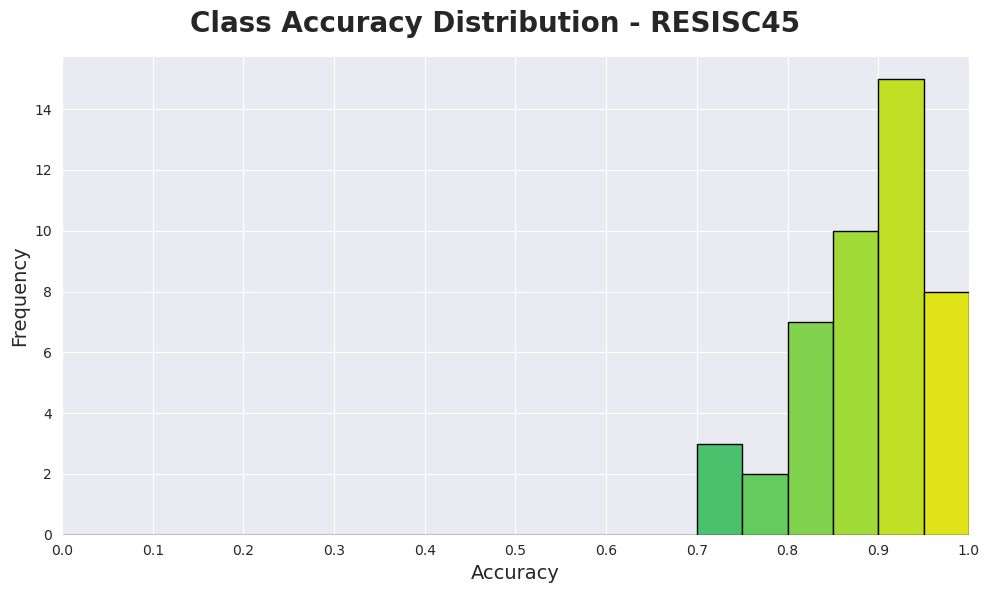

In [30]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [31]:
teacher_food101 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
get_model_params(teacher_food101)

Parameters: 80.87M


In [33]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

 90%|█████████ | 8546/9469 [10:12<01:04, 14.21it/s]/opt/conda/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [11:17<00:00, 13.97it/s]


Epochs: 1/10 | train_loss: 2.9341 | train_acc: 0.3617


100%|██████████| 9469/9469 [11:14<00:00, 14.04it/s]


Epochs: 2/10 | train_loss: 2.1197 | train_acc: 0.4956


100%|██████████| 9469/9469 [11:17<00:00, 13.99it/s]


Epochs: 3/10 | train_loss: 1.9041 | train_acc: 0.5365


100%|██████████| 9469/9469 [11:16<00:00, 14.00it/s]


Epochs: 4/10 | train_loss: 1.7831 | train_acc: 0.5611


100%|██████████| 9469/9469 [11:14<00:00, 14.04it/s]


Epochs: 5/10 | train_loss: 1.6960 | train_acc: 0.5774


100%|██████████| 9469/9469 [11:16<00:00, 14.00it/s]


Epochs: 6/10 | train_loss: 1.6404 | train_acc: 0.5904


100%|██████████| 9469/9469 [11:16<00:00, 13.99it/s]


Epochs: 7/10 | train_loss: 1.5847 | train_acc: 0.6023


100%|██████████| 9469/9469 [11:17<00:00, 13.98it/s]


Epochs: 8/10 | train_loss: 1.5430 | train_acc: 0.6111


100%|██████████| 9469/9469 [11:14<00:00, 14.03it/s]


Epochs: 9/10 | train_loss: 1.5062 | train_acc: 0.6216


100%|██████████| 9469/9469 [11:16<00:00, 14.00it/s]


Epochs: 10/10 | train_loss: 1.4793 | train_acc: 0.6256


In [34]:
deit_food101 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
get_model_params(deit_food101)

Parameters: 85.96M


In [36]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_food101,
)

100%|██████████| 9469/9469 [21:53<00:00,  7.21it/s]


Epochs: 1/10 | train_loss: 2.2052 | train_acc: 0.5531


100%|██████████| 9469/9469 [21:57<00:00,  7.18it/s]


Epochs: 2/10 | train_loss: 1.3678 | train_acc: 0.6861


100%|██████████| 9469/9469 [21:58<00:00,  7.18it/s]


Epochs: 3/10 | train_loss: 1.2366 | train_acc: 0.7150


100%|██████████| 9469/9469 [22:00<00:00,  7.17it/s]


Epochs: 4/10 | train_loss: 1.1712 | train_acc: 0.7340


100%|██████████| 9469/9469 [21:58<00:00,  7.18it/s]


Epochs: 5/10 | train_loss: 1.1287 | train_acc: 0.7452


100%|██████████| 9469/9469 [21:59<00:00,  7.18it/s]


Epochs: 6/10 | train_loss: 1.0974 | train_acc: 0.7543


100%|██████████| 9469/9469 [21:59<00:00,  7.17it/s]


Epochs: 7/10 | train_loss: 1.0731 | train_acc: 0.7606


100%|██████████| 9469/9469 [21:59<00:00,  7.18it/s]


Epochs: 8/10 | train_loss: 1.0531 | train_acc: 0.7665


100%|██████████| 9469/9469 [21:59<00:00,  7.17it/s]


Epochs: 9/10 | train_loss: 1.0365 | train_acc: 0.7714


100%|██████████| 9469/9469 [21:58<00:00,  7.18it/s]


Epochs: 10/10 | train_loss: 1.0223 | train_acc: 0.7757


In [37]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [05:37<00:00,  9.34it/s]


test_loss: 0.8135 | test_acc: 0.7863


In [38]:
food101_accs.append(food101_acc)

In [39]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.98),
 ('spaghetti carbonara', 0.968),
 ('pizza', 0.956),
 ('macarons', 0.952),
 ('pho', 0.948)]

In [40]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.404),
 ('pork chop', 0.456),
 ('apple pie', 0.476),
 ('ravioli', 0.524),
 ('chocolate mousse', 0.528)]

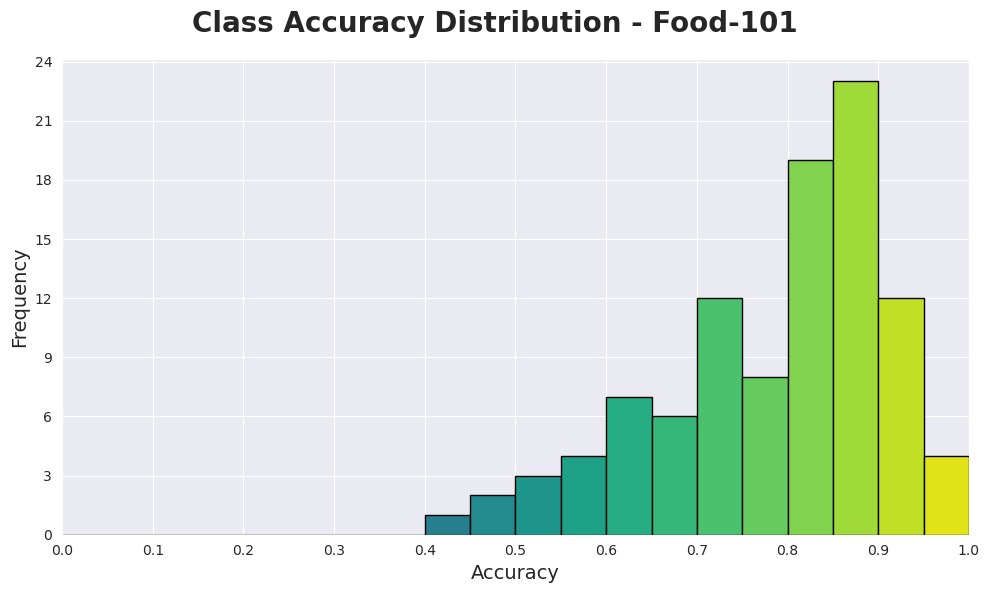

In [41]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [42]:
teacher_fer2013 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
get_model_params(teacher_fer2013)

Parameters: 80.59M


In [44]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 3589/3589 [02:51<00:00, 20.87it/s]


Epochs: 1/10 | train_loss: 1.6708 | train_acc: 0.3368


100%|██████████| 3589/3589 [02:53<00:00, 20.71it/s]


Epochs: 2/10 | train_loss: 1.5780 | train_acc: 0.3874


100%|██████████| 3589/3589 [02:53<00:00, 20.64it/s]


Epochs: 3/10 | train_loss: 1.5394 | train_acc: 0.4060


100%|██████████| 3589/3589 [02:51<00:00, 20.88it/s]


Epochs: 4/10 | train_loss: 1.5190 | train_acc: 0.4164


100%|██████████| 3589/3589 [02:52<00:00, 20.86it/s]


Epochs: 5/10 | train_loss: 1.5042 | train_acc: 0.4182


100%|██████████| 3589/3589 [02:51<00:00, 20.91it/s]


Epochs: 6/10 | train_loss: 1.4902 | train_acc: 0.4249


100%|██████████| 3589/3589 [02:51<00:00, 20.90it/s]


Epochs: 7/10 | train_loss: 1.4784 | train_acc: 0.4326


100%|██████████| 3589/3589 [02:51<00:00, 20.96it/s]


Epochs: 8/10 | train_loss: 1.4677 | train_acc: 0.4353


100%|██████████| 3589/3589 [02:51<00:00, 20.95it/s]


Epochs: 9/10 | train_loss: 1.4596 | train_acc: 0.4421


100%|██████████| 3589/3589 [02:51<00:00, 20.95it/s]

Epochs: 10/10 | train_loss: 1.4585 | train_acc: 0.4382


In [45]:
deit_fer2013 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
get_model_params(deit_fer2013)

Parameters: 85.81M


In [47]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_fer2013,
)

100%|██████████| 3589/3589 [06:59<00:00,  8.56it/s]


Epochs: 1/10 | train_loss: 1.4371 | train_acc: 0.4272


100%|██████████| 3589/3589 [06:59<00:00,  8.56it/s]


Epochs: 2/10 | train_loss: 1.2995 | train_acc: 0.4899


100%|██████████| 3589/3589 [06:58<00:00,  8.57it/s]


Epochs: 3/10 | train_loss: 1.2633 | train_acc: 0.5051


100%|██████████| 3589/3589 [07:00<00:00,  8.54it/s]


Epochs: 4/10 | train_loss: 1.2431 | train_acc: 0.5111


100%|██████████| 3589/3589 [06:58<00:00,  8.58it/s]


Epochs: 5/10 | train_loss: 1.2296 | train_acc: 0.5185


100%|██████████| 3589/3589 [06:58<00:00,  8.57it/s]


Epochs: 6/10 | train_loss: 1.2194 | train_acc: 0.5230


100%|██████████| 3589/3589 [06:59<00:00,  8.56it/s]


Epochs: 7/10 | train_loss: 1.2110 | train_acc: 0.5272


100%|██████████| 3589/3589 [06:58<00:00,  8.57it/s]


Epochs: 8/10 | train_loss: 1.2045 | train_acc: 0.5297


100%|██████████| 3589/3589 [06:58<00:00,  8.58it/s]


Epochs: 9/10 | train_loss: 1.1988 | train_acc: 0.5326


100%|██████████| 3589/3589 [07:00<00:00,  8.54it/s]


Epochs: 10/10 | train_loss: 1.1943 | train_acc: 0.5357


In [48]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:37<00:00, 11.88it/s]

test_loss: 1.2724 | test_acc: 0.5274


In [49]:
fer2013_accs.append(fer2013_acc)

In [50]:
fer2013_per_class_acc

{'angry': 0.3890020366598778,
 'disgust': 0.03636363636363636,
 'fear': 0.2178030303030303,
 'happy': 0.8771331058020477,
 'sad': 0.35185185185185186,
 'surprise': 0.6370192307692307,
 'neutral': 0.5431309904153354}

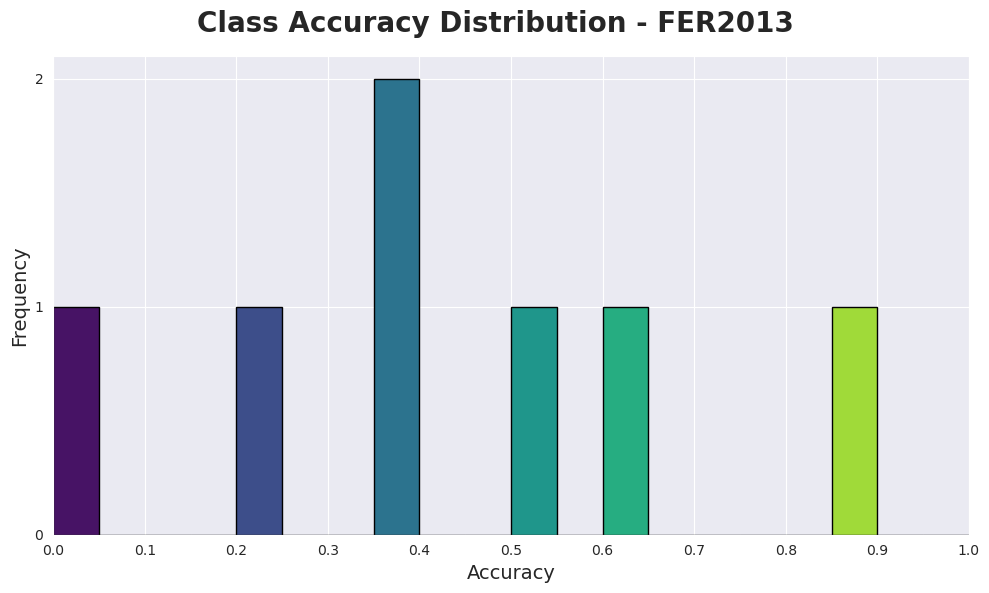

In [51]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [52]:
teacher_pcam = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
get_model_params(teacher_pcam)

Parameters: 80.57M


In [54]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 32768/32768 [26:50<00:00, 20.35it/s]


Epochs: 1/10 | train_loss: 0.4590 | train_acc: 0.7851


100%|██████████| 32768/32768 [26:54<00:00, 20.30it/s]


Epochs: 2/10 | train_loss: 0.4331 | train_acc: 0.8012


100%|██████████| 32768/32768 [26:50<00:00, 20.35it/s]


Epochs: 3/10 | train_loss: 0.4268 | train_acc: 0.8050


100%|██████████| 32768/32768 [26:49<00:00, 20.36it/s]


Epochs: 4/10 | train_loss: 0.4220 | train_acc: 0.8071


100%|██████████| 32768/32768 [26:53<00:00, 20.31it/s]


Epochs: 5/10 | train_loss: 0.4210 | train_acc: 0.8081


100%|██████████| 32768/32768 [26:48<00:00, 20.38it/s]


Epochs: 6/10 | train_loss: 0.4217 | train_acc: 0.8081


100%|██████████| 32768/32768 [26:53<00:00, 20.31it/s]


Epochs: 7/10 | train_loss: 0.4188 | train_acc: 0.8098


100%|██████████| 32768/32768 [26:50<00:00, 20.34it/s]


Epochs: 8/10 | train_loss: 0.4198 | train_acc: 0.8083


100%|██████████| 32768/32768 [26:53<00:00, 20.31it/s]


Epochs: 9/10 | train_loss: 0.4190 | train_acc: 0.8097


100%|██████████| 32768/32768 [26:52<00:00, 20.32it/s]

Epochs: 10/10 | train_loss: 0.4200 | train_acc: 0.8092


In [55]:
deit_pcam = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
get_model_params(deit_pcam)

Parameters: 85.80M


In [57]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True, 
    teacher=teacher_pcam,
)

100%|██████████| 32768/32768 [1:04:26<00:00,  8.47it/s]


Epochs: 1/10 | train_loss: 0.3210 | train_acc: 0.8564


100%|██████████| 32768/32768 [1:04:25<00:00,  8.48it/s]


Epochs: 3/10 | train_loss: 0.2927 | train_acc: 0.8757


100%|██████████| 32768/32768 [1:04:22<00:00,  8.48it/s]


Epochs: 4/10 | train_loss: 0.2905 | train_acc: 0.8776


100%|██████████| 32768/32768 [1:04:25<00:00,  8.48it/s]


Epochs: 5/10 | train_loss: 0.2892 | train_acc: 0.8786


100%|██████████| 32768/32768 [1:04:22<00:00,  8.48it/s]


Epochs: 6/10 | train_loss: 0.2884 | train_acc: 0.8799


100%|██████████| 32768/32768 [1:04:23<00:00,  8.48it/s]


Epochs: 7/10 | train_loss: 0.2879 | train_acc: 0.8800


100%|██████████| 32768/32768 [1:04:27<00:00,  8.47it/s]


Epochs: 8/10 | train_loss: 0.2874 | train_acc: 0.8803


100%|██████████| 32768/32768 [1:04:27<00:00,  8.47it/s]


Epochs: 9/10 | train_loss: 0.2872 | train_acc: 0.8807


100%|██████████| 32768/32768 [1:04:26<00:00,  8.47it/s]

Epochs: 10/10 | train_loss: 0.2869 | train_acc: 0.8810


In [58]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [05:50<00:00, 11.69it/s]

test_loss: 0.3768 | test_acc: 0.8323


In [59]:
pcam_accs.append(pcam_acc)

In [60]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.899151973644073,
 'lymph node tumor tissue': 0.7654637601514319}

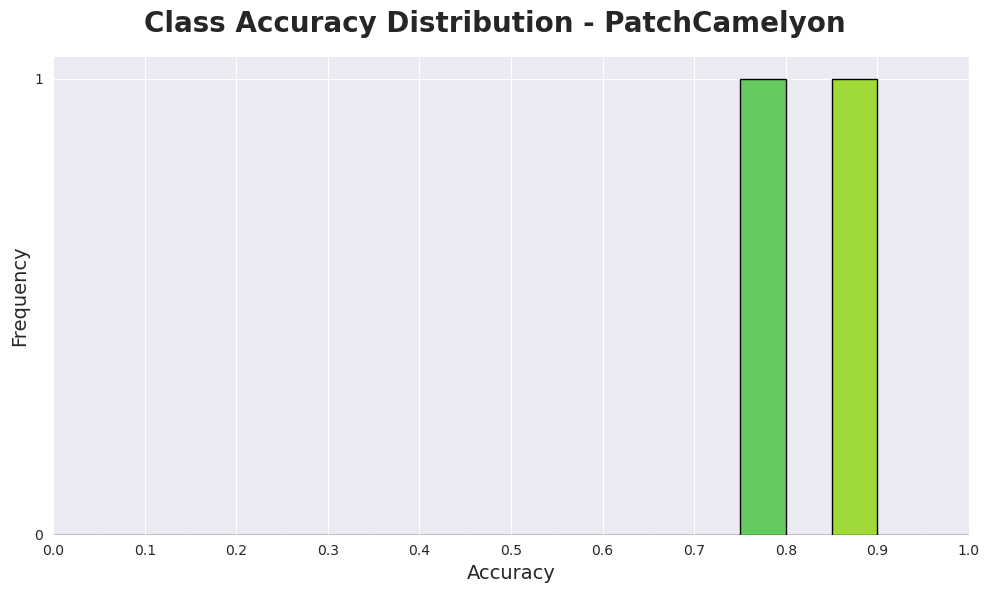

In [ ]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [ ]:
teacher_sun397 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(teacher_sun397)

Parameters: 81.77M


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 9516/9516 [11:50<00:00, 13.39it/s]


Epochs: 1/10 | train_loss: 2.9245 | train_acc: 0.3947


100%|██████████| 9516/9516 [11:33<00:00, 13.72it/s]


Epochs: 2/10 | train_loss: 1.8298 | train_acc: 0.5477


100%|██████████| 9516/9516 [11:33<00:00, 13.72it/s]


Epochs: 3/10 | train_loss: 1.5869 | train_acc: 0.5920


100%|██████████| 9516/9516 [11:35<00:00, 13.68it/s]


Epochs: 4/10 | train_loss: 1.4511 | train_acc: 0.6206


100%|██████████| 9516/9516 [11:34<00:00, 13.71it/s]


Epochs: 5/10 | train_loss: 1.3508 | train_acc: 0.6406


100%|██████████| 9516/9516 [11:32<00:00, 13.73it/s]


Epochs: 6/10 | train_loss: 1.2782 | train_acc: 0.6579


100%|██████████| 9516/9516 [11:33<00:00, 13.71it/s]


Epochs: 7/10 | train_loss: 1.2240 | train_acc: 0.6698


100%|██████████| 9516/9516 [11:35<00:00, 13.68it/s]


Epochs: 8/10 | train_loss: 1.1658 | train_acc: 0.6829


100%|██████████| 9516/9516 [11:31<00:00, 13.76it/s]


Epochs: 9/10 | train_loss: 1.1321 | train_acc: 0.6901


100%|██████████| 9516/9516 [11:32<00:00, 13.74it/s]


Epochs: 10/10 | train_loss: 1.0909 | train_acc: 0.7012


In [ ]:
deit_sun397 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(deit_sun397)

Parameters: 86.41M


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_sun397,
)

100%|██████████| 9516/9516 [22:28<00:00,  7.06it/s]


Epochs: 1/10 | train_loss: 2.6413 | train_acc: 0.5070


100%|██████████| 9516/9516 [22:25<00:00,  7.08it/s]


Epochs: 2/10 | train_loss: 1.2069 | train_acc: 0.6951


100%|██████████| 9516/9516 [22:26<00:00,  7.07it/s]


Epochs: 3/10 | train_loss: 0.9977 | train_acc: 0.7373


100%|██████████| 9516/9516 [22:24<00:00,  7.08it/s]


Epochs: 4/10 | train_loss: 0.8986 | train_acc: 0.7604


100%|██████████| 9516/9516 [22:25<00:00,  7.07it/s]


Epochs: 5/10 | train_loss: 0.8333 | train_acc: 0.7775


100%|██████████| 9516/9516 [22:24<00:00,  7.08it/s]


Epochs: 6/10 | train_loss: 0.7840 | train_acc: 0.7893


100%|██████████| 9516/9516 [22:26<00:00,  7.07it/s]


Epochs: 7/10 | train_loss: 0.7449 | train_acc: 0.8011


100%|██████████| 9516/9516 [22:25<00:00,  7.07it/s]


Epochs: 8/10 | train_loss: 0.7127 | train_acc: 0.8097


100%|██████████| 9516/9516 [22:24<00:00,  7.08it/s]


Epochs: 9/10 | train_loss: 0.6848 | train_acc: 0.8164


100%|██████████| 9516/9516 [22:23<00:00,  7.08it/s]


Epochs: 10/10 | train_loss: 0.6606 | train_acc: 0.8225


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [04:58<00:00,  9.10it/s]


test_loss: 0.9821 | test_acc: 0.7269


In [ ]:
sun397_accs.append(sun397_acc)

In [ ]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('raft', 1.0),
 ('cockpit', 0.9850746268656716),
 ('oilrig', 0.9833333333333333),
 ('underwater (coral reef)', 0.9827586206896551)]

In [ ]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bistro (indoor)', 0.0),
 ('library (outdoor)', 0.047619047619047616),
 ('inn (outdoor)', 0.06896551724137931),
 ('recreation room', 0.07407407407407407),
 ('kitchenette', 0.07692307692307693)]

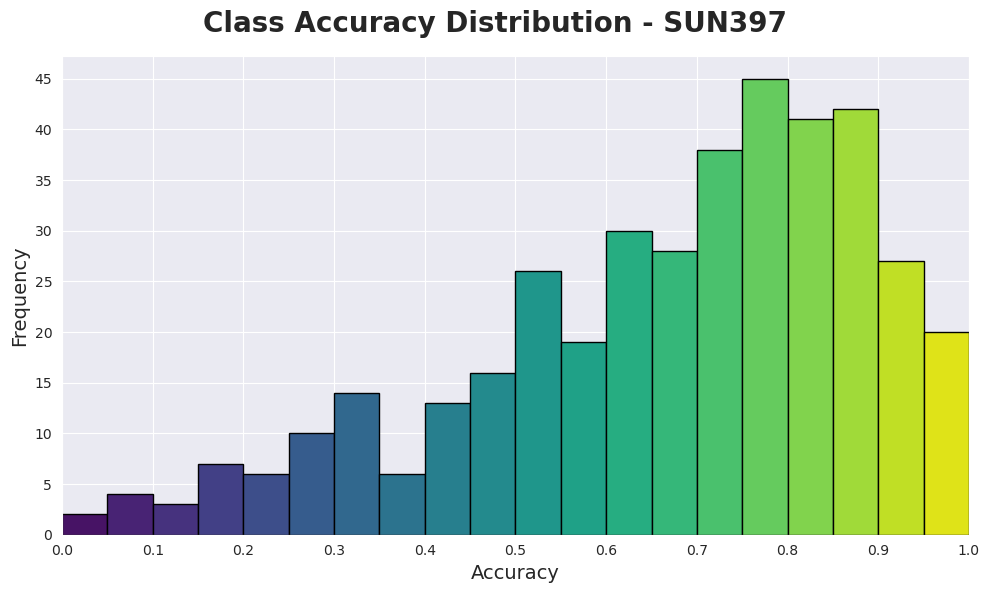

In [ ]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [ ]:
teacher_dtd = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(teacher_dtd)

Parameters: 80.71M


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=False,
)

100%|██████████| 470/470 [00:35<00:00, 13.33it/s]


Epochs: 1/10 | train_loss: 3.1863 | train_acc: 0.2755


100%|██████████| 470/470 [00:35<00:00, 13.38it/s]


Epochs: 2/10 | train_loss: 2.3744 | train_acc: 0.4883


100%|██████████| 470/470 [00:35<00:00, 13.41it/s]


Epochs: 3/10 | train_loss: 1.9845 | train_acc: 0.5465


100%|██████████| 470/470 [00:35<00:00, 13.40it/s]


Epochs: 4/10 | train_loss: 1.7645 | train_acc: 0.5774


100%|██████████| 470/470 [00:35<00:00, 13.42it/s]


Epochs: 5/10 | train_loss: 1.6377 | train_acc: 0.5904


100%|██████████| 470/470 [00:35<00:00, 13.34it/s]


Epochs: 6/10 | train_loss: 1.5253 | train_acc: 0.6069


100%|██████████| 470/470 [00:36<00:00, 13.03it/s]


Epochs: 7/10 | train_loss: 1.4586 | train_acc: 0.6138


100%|██████████| 470/470 [00:35<00:00, 13.13it/s]


Epochs: 8/10 | train_loss: 1.3717 | train_acc: 0.6359


100%|██████████| 470/470 [00:35<00:00, 13.27it/s]


Epochs: 9/10 | train_loss: 1.3434 | train_acc: 0.6386


100%|██████████| 470/470 [00:34<00:00, 13.46it/s]

Epochs: 10/10 | train_loss: 1.2884 | train_acc: 0.6543


In [ ]:
deit_dtd = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(deit_dtd)

Parameters: 85.87M


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=False,
    with_distillation=True,
    teacher=teacher_dtd,
)

100%|██████████| 470/470 [01:07<00:00,  7.00it/s]


Epochs: 1/10 | train_loss: 3.4533 | train_acc: 0.2210


100%|██████████| 470/470 [01:07<00:00,  7.01it/s]


Epochs: 2/10 | train_loss: 2.5941 | train_acc: 0.5625


100%|██████████| 470/470 [01:07<00:00,  7.01it/s]


Epochs: 3/10 | train_loss: 2.0212 | train_acc: 0.6465


100%|██████████| 470/470 [01:06<00:00,  7.04it/s]


Epochs: 4/10 | train_loss: 1.6610 | train_acc: 0.6867


100%|██████████| 470/470 [01:06<00:00,  7.04it/s]


Epochs: 5/10 | train_loss: 1.4270 | train_acc: 0.7077


100%|██████████| 470/470 [01:06<00:00,  7.04it/s]


Epochs: 6/10 | train_loss: 1.2673 | train_acc: 0.7250


100%|██████████| 470/470 [01:06<00:00,  7.04it/s]


Epochs: 7/10 | train_loss: 1.1505 | train_acc: 0.7388


100%|██████████| 470/470 [01:06<00:00,  7.04it/s]


Epochs: 8/10 | train_loss: 1.0614 | train_acc: 0.7521


100%|██████████| 470/470 [01:06<00:00,  7.02it/s]


Epochs: 9/10 | train_loss: 0.9902 | train_acc: 0.7620


100%|██████████| 470/470 [01:06<00:00,  7.03it/s]

Epochs: 10/10 | train_loss: 0.9322 | train_acc: 0.7702


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:25<00:00,  9.16it/s]

test_loss: 1.1436 | test_acc: 0.7149


In [ ]:
dtd_accs.append(dtd_acc)

In [ ]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.95),
 ('knitted', 0.95),
 ('cobwebbed', 0.925),
 ('banded', 0.9),
 ('chequered', 0.9)]

In [ ]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('pitted', 0.3),
 ('blotchy', 0.35),
 ('stained', 0.45),
 ('woven', 0.475),
 ('porous', 0.5)]

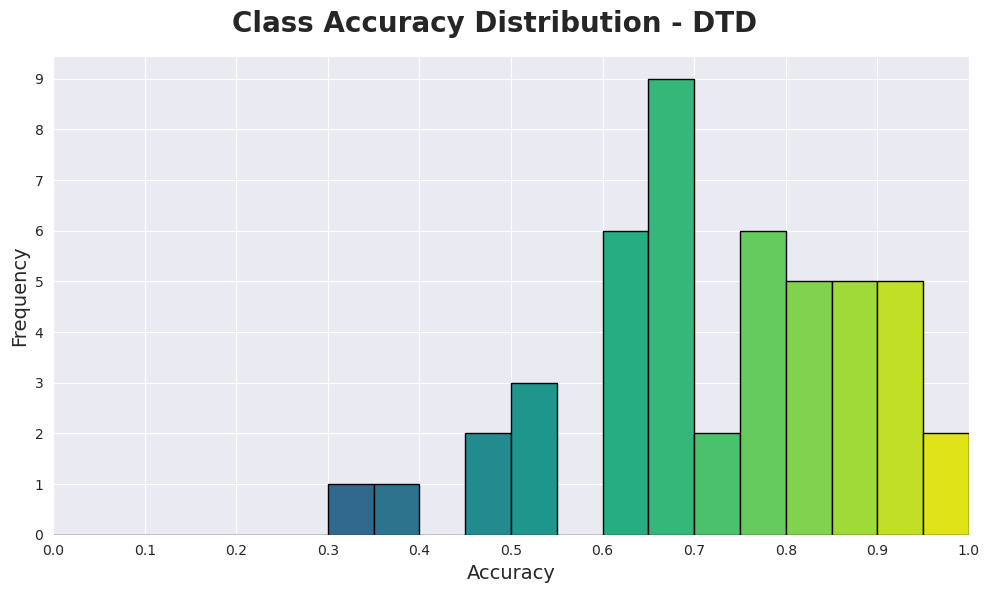

In [ ]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [ ]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [ ]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [ ]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [ ]:
df = pd.DataFrame(results, columns=['linear probe'], index=labels)
df

,linear probe
RESISC45,0.886667
Food-101,0.786297
FER2013,0.527445
PatchCamelyon,0.832336
SUN397,0.726851
DTD,0.714894
